In [1]:
import pandas as pd
import sklearn
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string

# allow display of multiple outputs by running one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



C:\Users\fatma\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\fatma\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\fatma\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data = pd.read_csv('Data/final_data_en.csv', index_col='id')
data.head()


,Unnamed: 0,location,tweetcreatedts,text,class
id,,,,,
1039,9604,the nationwood street,2021-02-08 19:07:40+00:00,RT @maideeeni: I want to say a very big thank ...,anxiety
1682,1682,RH Waiting For Update Planet,2021-02-03 23:58:40+00:00,@AisYalcaE @clyrhck Done! I just need 320! Tha...,lonely
5275,5275,Any pronouns ¡ GMT+8,2021-01-27 23:57:59+00:00,@SAD_istfied I'm gonna cry /pos,stress
6069,6069,........,2021-02-03 23:58:23+00:00,RT @JoshOfficial___: I need a consistent fuck ...,anxiety
6087,6087,"St Louis, MO",2021-02-12 20:27:58+00:00,RT @mikegolicjr: glad we're finally talking ab...,normal


In [3]:
data = data.drop(data.columns[0], axis=1)
data

,location,tweetcreatedts,text,class
id,,,,
1039,the nationwood street,2021-02-08 19:07:40+00:00,RT @maideeeni: I want to say a very big thank ...,anxiety
1682,RH Waiting For Update Planet,2021-02-03 23:58:40+00:00,@AisYalcaE @clyrhck Done! I just need 320! Tha...,lonely
5275,Any pronouns ¡ GMT+8,2021-01-27 23:57:59+00:00,@SAD_istfied I'm gonna cry /pos,stress
6069,........,2021-02-03 23:58:23+00:00,RT @JoshOfficial___: I need a consistent fuck ...,anxiety
6087,"St Louis, MO",2021-02-12 20:27:58+00:00,RT @mikegolicjr: glad we're finally talking ab...,normal
...,...,...,...,...
7813,"Charlotte, NC",2021-01-27 23:58:57+00:00,Im nervous ash to fly though,anxiety
1305,NaN,2021-02-03 23:58:58+00:00,64E7B6DA :Battle ID\nI need backup!\nLvl 120 G...,lonely
5192,"Doylestown, PA",2021-02-03 23:59:01+00:00,SNOW MUCH FUN writing about our snow days in @...,anxiety


In [4]:
#find duplicate rows across all columns
print('Number of the duplicated rows= ',data.duplicated().sum())

# summary of the number of nulls
print('Total missing values = ', data.isna().sum().sum())

print('Number of nulls in each column:')
data.isna().sum()
print('________________________________________________________________')

# count the ratio of missing values
total_miss = data.isnull().sum()
percent_miss = (total_miss/data.isnull().count()*100)

# sort attributes by missing value ratio
missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
missing_data.sort_values(by='Total missing',ascending=False)

Number of the duplicated rows=  7763
Total missing values =  13084
Number of nulls in each column:


location          13084
tweetcreatedts        0
text                  0
class                 0
dtype: int64

________________________________________________________________


,Total missing,% missing
location,13084,32.90248
tweetcreatedts,0,0.00000
text,0,0.00000
class,0,0.00000


In [5]:
data['class'].value_counts()

anxiety    12585
normal     10022
stress      8599
lonely      8560
Name: class, dtype: int64

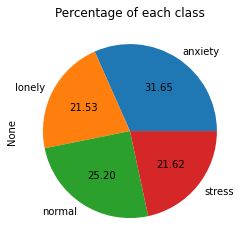

In [17]:
plot = data.groupby('class').size().plot.pie(autopct='%.2f', y='percentage', title='Percentage of each class')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Class Distribution Over Entries')

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Frequency')

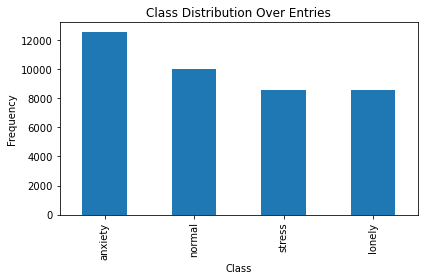

In [7]:
plt.figure()
ax = data['class'].value_counts().plot(kind='bar')

ax.set_title('Class Distribution Over Entries')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [40]:
# let's use standard english stop-words first, later we would see if we need to filter specific stopwords (high-frequent words with no discriminative power)
cachedStopWords = list(esw)
lemmatizer=WordNetLemmatizer()
#ps = PorterStemmer()

def lemmatize_article(sentence):
    sentence = word_tokenize(sentence)
    res = ''
    for word, tag in pos_tag(sentence):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        word = lemmatizer.lemmatize(word, wntag) if wntag else word
        res += word + ' '
    return res


def remove_stop_words(sentence):
    return ' '.join([word for word in sentence.split() if word not in cachedStopWords])
    
def remove_short(sentence):
    return ' '.join([word for word in sentence.split() if len(word) >= 3])
    
def remove_digits(sentence):
    return ' '.join([i for i in sentence.split() if not i.isdigit()])
    
def preprocess(all_texts):
    all_texts = list(map(lambda x: x.lower(), all_texts))
    all_texts = list(map(lambda x: x.translate(str.maketrans('', '', string.punctuation)), all_texts))
    all_texts = list(map(lambda x: lemmatize_article(x), all_texts))
    all_texts = list(map(lambda x: x.strip(), all_texts))
    all_texts = list(map(lambda x: remove_stop_words(x), all_texts))
    all_texts = list(map(lambda x: remove_short(x), all_texts))
    all_texts = list(map(lambda x: remove_digits(x), all_texts))
    return all_texts
    

In [39]:
# remove mentions and urls
data['text_without'] = data['text'].str.replace(r'\s*@\w+', '', regex = True)
data['text_without'] = data['text'].str.replace(r'\s*\B@\w+', '', regex = True)
data['text_without'] = data['text'].str.replace(r'\s*@\S+', '', regex = True)
data['text_without'] = data['text'].str.replace(r'\s*@\S+\b', '', regex = True)
data['text_without'] = data['text_without'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
data

,location,tweetcreatedts,text,class,text_without
id,,,,,
1039,the nationwood street,2021-02-08 19:07:40+00:00,RT @maideeeni: I want to say a very big thank ...,anxiety,RT: I want to say a very big thank you to ever...
1682,RH Waiting For Update Planet,2021-02-03 23:58:40+00:00,@AisYalcaE @clyrhck Done! I just need 320! Tha...,lonely,Done! I just need 320! Thanks for the chance!
5275,Any pronouns ¡ GMT+8,2021-01-27 23:57:59+00:00,@SAD_istfied I'm gonna cry /pos,stress,I'm gonna cry /pos
6069,........,2021-02-03 23:58:23+00:00,RT @JoshOfficial___: I need a consistent fuck ...,anxiety,RT: I need a consistent fuck buddy
6087,"St Louis, MO",2021-02-12 20:27:58+00:00,RT @mikegolicjr: glad we're finally talking ab...,normal,RT: glad we're finally talking about Deshaun a...
...,...,...,...,...,...
7813,"Charlotte, NC",2021-01-27 23:58:57+00:00,Im nervous ash to fly though,anxiety,Im nervous ash to fly though
1305,NaN,2021-02-03 23:58:58+00:00,64E7B6DA :Battle ID\nI need backup!\nLvl 120 G...,lonely,64E7B6DA :Battle ID\nI need backup!\nLvl 120 G...
5192,"Doylestown, PA",2021-02-03 23:59:01+00:00,SNOW MUCH FUN writing about our snow days in @...,anxiety,SNOW MUCH FUN writing about our snow days in t...


In [41]:
# preprocess text
data['text_cleaned'] = preprocess(data['text_without'])
data

,location,tweetcreatedts,text,class,text_without,text_cleaned
id,,,,,,
1039,the nationwood street,2021-02-08 19:07:40+00:00,RT @maideeeni: I want to say a very big thank ...,anxiety,RT: I want to say a very big thank you to ever...,want say big thank single reach just make sure...
1682,RH Waiting For Update Planet,2021-02-03 23:58:40+00:00,@AisYalcaE @clyrhck Done! I just need 320! Tha...,lonely,Done! I just need 320! Thanks for the chance!,just need thanks chance
5275,Any pronouns ¡ GMT+8,2021-01-27 23:57:59+00:00,@SAD_istfied I'm gonna cry /pos,stress,I'm gonna cry /pos,gon
6069,........,2021-02-03 23:58:23+00:00,RT @JoshOfficial___: I need a consistent fuck ...,anxiety,RT: I need a consistent fuck buddy,need consistent fuck buddy
6087,"St Louis, MO",2021-02-12 20:27:58+00:00,RT @mikegolicjr: glad we're finally talking ab...,normal,RT: glad we're finally talking about Deshaun a...,glad finally talk deshaun denver loud
...,...,...,...,...,...,...
7813,"Charlotte, NC",2021-01-27 23:58:57+00:00,Im nervous ash to fly though,anxiety,Im nervous ash to fly though,nervous ash fly
1305,NaN,2021-02-03 23:58:58+00:00,64E7B6DA :Battle ID\nI need backup!\nLvl 120 G...,lonely,64E7B6DA :Battle ID\nI need backup!\nLvl 120 G...,64e7b6da battle need backup lvl grimnir
5192,"Doylestown, PA",2021-02-03 23:59:01+00:00,SNOW MUCH FUN writing about our snow days in @...,anxiety,SNOW MUCH FUN writing about our snow days in t...,snow fun write snow day today blast writing sh...


In [42]:
data = pd.DataFrame(data)
data.head()

,location,tweetcreatedts,text,class,text_without,text_cleaned
id,,,,,,
1039,the nationwood street,2021-02-08 19:07:40+00:00,RT @maideeeni: I want to say a very big thank ...,anxiety,RT: I want to say a very big thank you to ever...,want say big thank single reach just make sure...
1682,RH Waiting For Update Planet,2021-02-03 23:58:40+00:00,@AisYalcaE @clyrhck Done! I just need 320! Tha...,lonely,Done! I just need 320! Thanks for the chance!,just need thanks chance
5275,Any pronouns ¡ GMT+8,2021-01-27 23:57:59+00:00,@SAD_istfied I'm gonna cry /pos,stress,I'm gonna cry /pos,gon
6069,........,2021-02-03 23:58:23+00:00,RT @JoshOfficial___: I need a consistent fuck ...,anxiety,RT: I need a consistent fuck buddy,need consistent fuck buddy
6087,"St Louis, MO",2021-02-12 20:27:58+00:00,RT @mikegolicjr: glad we're finally talking ab...,normal,RT: glad we're finally talking about Deshaun a...,glad finally talk deshaun denver loud


<Figure size 2880x4320 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'lonely')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'normal')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'anxiety')

(0.0, 1.0, 0.0, 1.0)

Text(0.5, 1.0, 'stress')

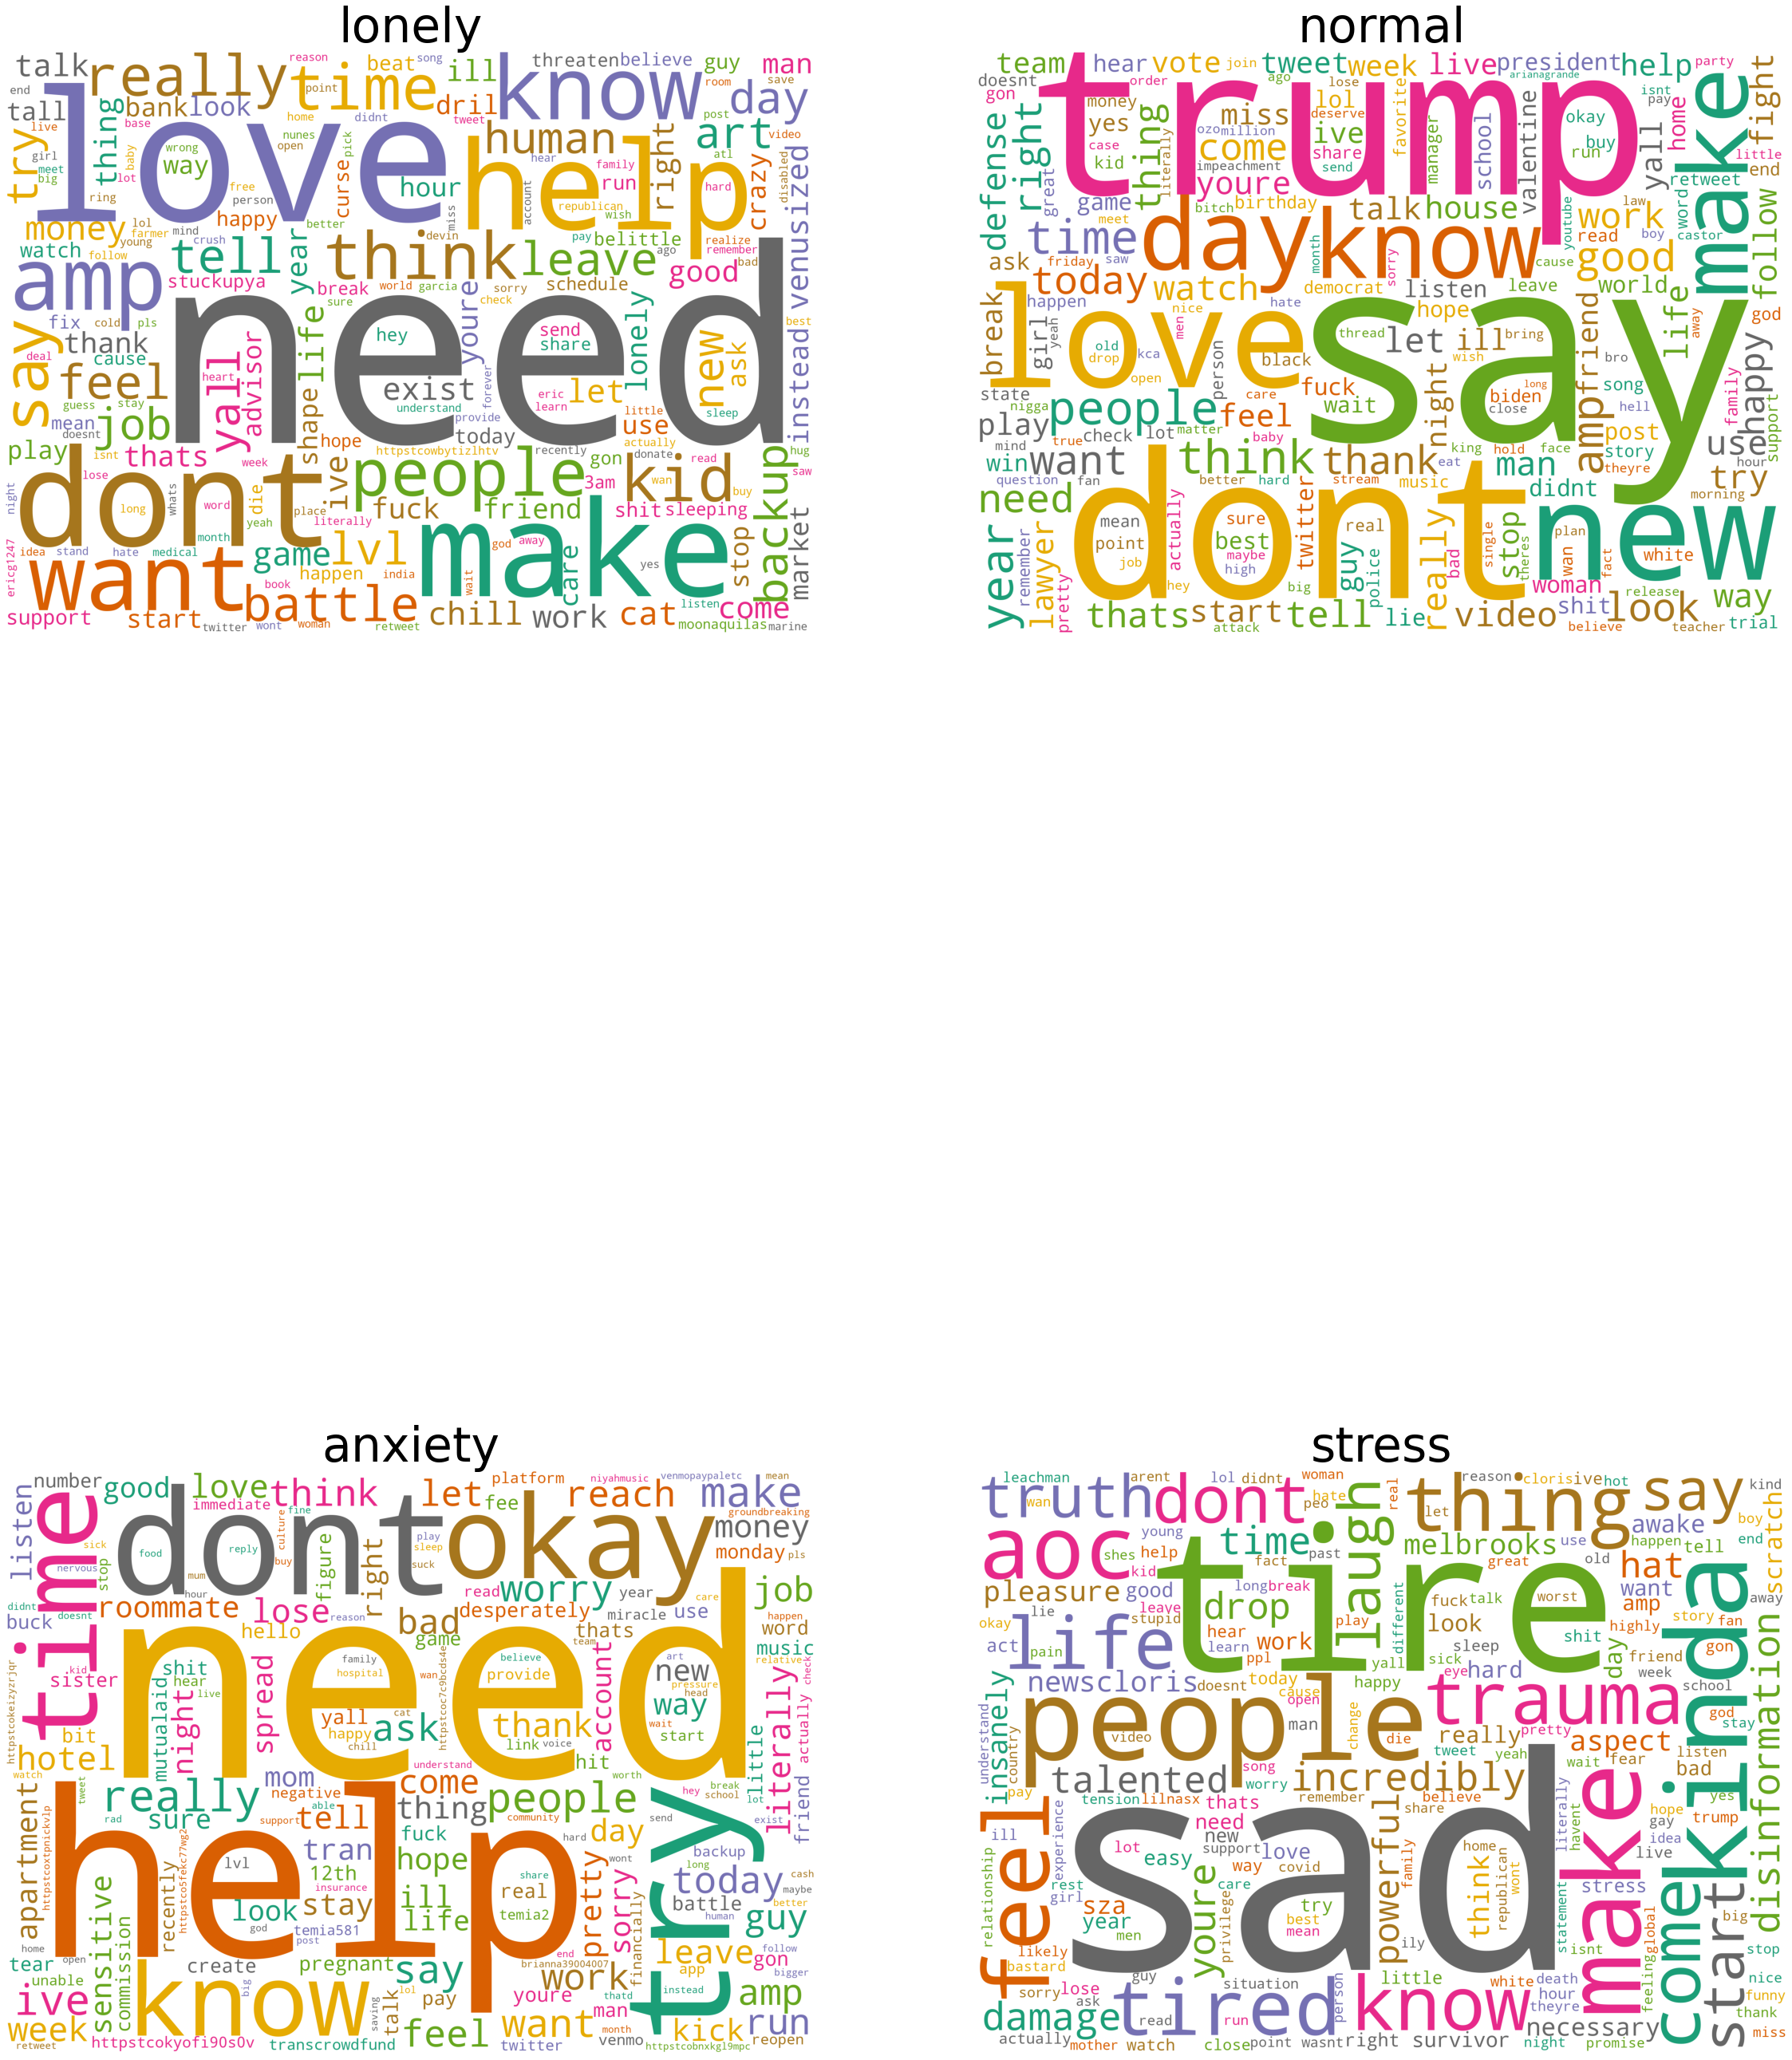

In [68]:
from wordcloud import WordCloud,STOPWORDS


plt.figure(figsize=(40,60))
subset = data[data['class']=='lonely']
text_cleaned = subset.text_cleaned.values
cloud1=WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,1)
plt.axis('off')
plt.title("lonely",fontsize=60)
plt.imshow(cloud1)


subset = data[data['class']=='normal']
text_cleaned = subset.text_cleaned.values
cloud2 = WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,2)
plt.axis('off')
plt.title("normal",fontsize=60)
plt.imshow(cloud2)

subset = data[data['class']=='anxiety']
text_cleaned = subset.text_cleaned.values
cloud3 = WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,3)
plt.axis('off')
plt.title("anxiety",fontsize=60)
plt.imshow(cloud3)


subset = data[data['class']=='stress']
text_cleaned = subset.text_cleaned.values
cloud4 = WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text_cleaned))

plt.subplot(2,2,4)
plt.axis('off')
plt.title("stress",fontsize=60)
plt.imshow(cloud4)


In [43]:
# tokenization
tokenized_tweet = data['text_cleaned'].apply(lambda x: x.split())
tokenized_tweet.head()

id
1039    [want, say, big, thank, single, reach, just, m...
1682                         [just, need, thanks, chance]
5275                                                [gon]
6069                      [need, consistent, fuck, buddy]
6087         [glad, finally, talk, deshaun, denver, loud]
Name: text_cleaned, dtype: object

In [70]:
data.head()

,location,tweetcreatedts,text,class,text_cleaned
id,,,,,
1039,the nationwood street,2021-02-08 19:07:40+00:00,RT @maideeeni: I want to say a very big thank ...,anxiety,maideeeni want say big thank single reach just...
1682,RH Waiting For Update Planet,2021-02-03 23:58:40+00:00,@AisYalcaE @clyrhck Done! I just need 320! Tha...,lonely,aisyalcae clyrhck just need thanks chance
5275,Any pronouns ¡ GMT+8,2021-01-27 23:57:59+00:00,@SAD_istfied I'm gonna cry /pos,stress,sadistfied gon
6069,........,2021-02-03 23:58:23+00:00,RT @JoshOfficial___: I need a consistent fuck ...,anxiety,joshofficial need consistent fuck buddy
6087,"St Louis, MO",2021-02-12 20:27:58+00:00,RT @mikegolicjr: glad we're finally talking ab...,normal,mikegolicjr glad finally talk deshaun denver loud


In [44]:
# word2vec

import gensim
model_w2v = gensim.models.Word2Vec(
                                   tokenized_tweet,
#                                    size = 200, # desired no. of features
                                  window = 5, # context window size
                                    min_count=1,
                                   sg = 1, # 1 for skipe-gram model
                                   hs = 0,
                                   negative = 10, # for negative sampling
                                   workers = 2, # no. of cores
                                   seed = 34
                                  )
        
                                   

model_w2v.train(tokenized_tweet, total_examples = len(data['text_cleaned']), epochs = 20)

# model_w2v.wv.most_similar(positive = "dinner")

(6386008, 7311720)

[('molest', 0.6419351696968079),
 ('gt13000', 0.6366086602210999),
 ('50p', 0.6044559478759766),
 ('kraft', 0.6031100153923035),
 ('cooky', 0.5859058499336243),
 ('metroid', 0.5854609608650208),
 ('donghae', 0.5775980949401855),
 ('ramen', 0.5738505125045776),
 ('creamer', 0.560967743396759),
 ('umm', 0.5586989521980286)]

In [72]:
# model_w2v.wv.most_similar(positive = "trump")

[('donald', 0.7213981747627258),
 ('lawyer', 0.7046241760253906),
 ('defense', 0.7024080157279968),
 ('impeachment', 0.6834219694137573),
 ('glennkirschner2', 0.6585119366645813),
 ('deplorable', 0.656413733959198),
 ('cruz', 0.6482923030853271),
 ('barbmcquade', 0.6447924971580505),
 ('funder', 0.6436319947242737),
 ('incite', 0.6420890688896179)]

[('donald', 0.7213981747627258),
 ('lawyer', 0.7046241760253906),
 ('defense', 0.7024080157279968),
 ('impeachment', 0.6834219694137573),
 ('glennkirschner2', 0.6585119366645813),
 ('deplorable', 0.656413733959198),
 ('cruz', 0.6482923030853271),
 ('barbmcquade', 0.6447924971580505),
 ('funder', 0.6436319947242737),
 ('incite', 0.6420890688896179)]

In [54]:
len(model_w2v.wv['food'])

100

In [52]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec +=model_w2v.wv[word].reshape((1, size))
            count += 1
        except KeyError: # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
        return vec

In [59]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 600))
for i in range (len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 600)
    wordvec_df = pd.DataFrame(wordvec_arrays)
    wordvec_df.shape

ValueError: cannot reshape array of size 1200 into shape (1,600)

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df =2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['text_cleaned'])
tfidf.shape

(39766, 1000)

In [62]:
tfidf

<39766x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 247532 stored elements in Compressed Sparse Row format>

In [63]:
X = tfidf
y = data['class']

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)


In [65]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

SVC(kernel='linear')

In [66]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7684828164291702


In [67]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(max_depth = 6, n_estimators = 1000).fit(X_train, y_train)

#Predict the response for test dataset
y_pred = xgb_model.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

C:\Users\fatma\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7918692372170998
